Previous: [pipeline_experiment](pipeline_experiment.ipynb)  ::: Next [pipeline_vis](pipeline_vis.ipynb)

# Schema `preprocess`

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 8)  # make figures bigger

Populating the interactive namespace from numpy and matplotlib


The `preprocess` schema extracts, aligns, and synchronizes multiphoton trace data from both galvo and AOD systems.

In [2]:
import datajoint as dj
from pipeline import preprocess

DataJoint 0.3.2 (July 18, 2016)
Loading local settings from dj_local_conf.json
Connecting dimitri@datajoint.ninai.org:3306


The ERD of the preprocess schema is a bit more complicated:

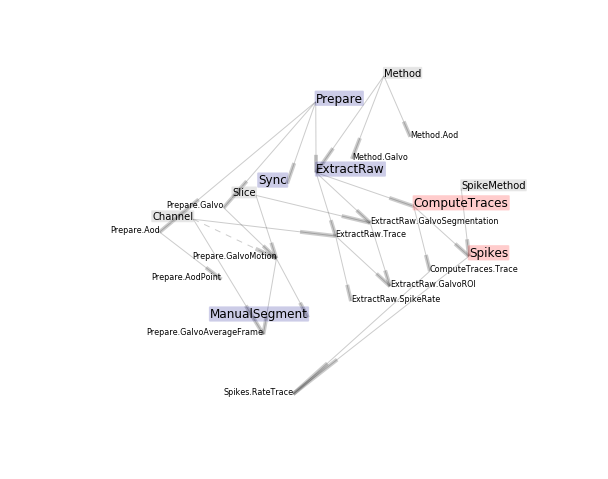

In [3]:
dj.ERD(preprocess).draw()

Including some upstream tables from `experiment`:

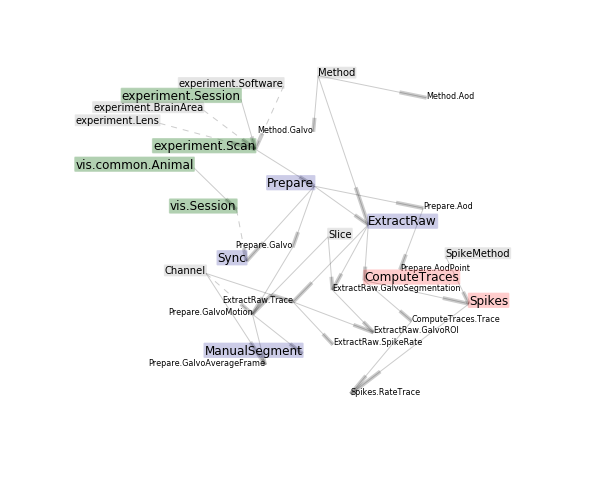

In [4]:
(dj.ERD(preprocess) - 2).draw()

However, you may plot a portion of the ERD starting with any table.  Here +1 means go one level down along dependencies and -1 means go one level up from all nodes:

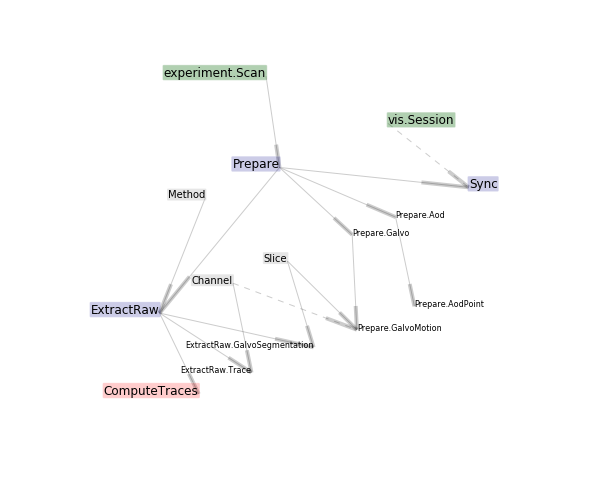

In [5]:
(dj.ERD(preprocess.Prepare())+2-1).draw()

The color code is the following: 
* Green (e.g. `experiment.Scan`) is data entered *manual* or by external software
* Blue (e.g. `preprocess.Prepare`) is data that is *imported* from external files by datajoint.
* Red (e.g. `preprocess.ComputeTraces`) is data that is *computed* by datajoint using data that is already in the database without access to external files.
* Gray (e.g. `preprocess.Method`) are *lookup* tables containing general information that is not specific each experiment.  These often contain processing settings and common knowledge. 
* In small font are part tables (e.g. `preprocess.Prepare.Galvo`).  These contain information listing additional details for its master table, its outer nesting class.

## Example: fetching and plotting average images of scans.
Many tables contain attributes of type `blob` or `longblob`, which contain array information such as images and traces:

In [6]:
preprocess.Prepare.GalvoAverageFrame().heading

# average frame for each slice and channel after corrections
animal_id            : int                          # id number
session              : smallint                     # session index for the mouse
scan_idx             : smallint                     # number of TIFF stack file
slice                : tinyint                      # slice in scan
channel              : tinyint                      # 
---
frame                : longblob                     # average frame ater Anscombe, max-weighting,

---
If you know the exact identity of the scan of interest, use it as restriction:

In [7]:
frames = preprocess.Prepare.GalvoAverageFrame() & dict(animal_id=8623, slice=3, scan_idx=6)
frames

animal_id,session,scan_idx,slice,channel
8623,1,6,3,1
8623,1,6,3,2


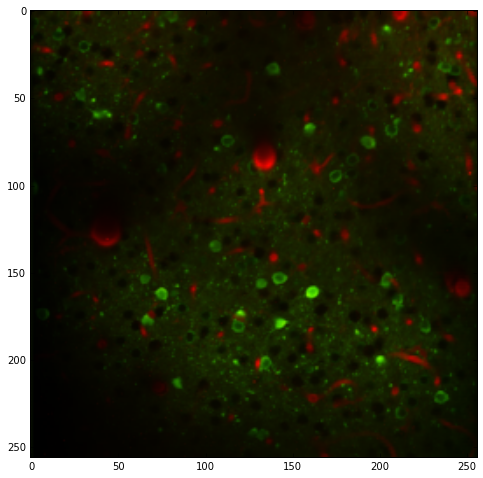

In [8]:
# fetch data
g, r = frames.fetch.order_by('channel')['frame']

# plot data
normalize = lambda x: (x - x.min())/(x.max()-x.min())
plt.imshow(np.stack(
        [normalize(r), normalize(g), np.zeros_like(r)], 2))

---
Alternatively, get a whole set of scans matching some condition.

In [9]:
from pipeline import experiment
experiment.Fluorophore()

fluorophore,dye_description
GCaMP6f,
GCaMP6s,
mCherry,
mRuby,
OGB,
tdTomato,
Twitch2B,


In [10]:
# select all slices imaged with GCaMP6f
slices = preprocess.Prepare()*preprocess.Slice() & (
    experiment.Session.Fluorophore() & 'fluorophore="GCaMP6f"') & preprocess.Prepare.GalvoAverageFrame()
slices    

animal_id,session,scan_idx,slice
8487,1,5,1
8487,1,5,2
8487,1,5,3
8487,1,6,1
8487,1,6,2
8487,1,6,3
8487,1,7,1


---
To address each entity in the set, get its primary key values with the `fetch.keys()` iterator. Then each key can be used in a restriction.

In [11]:
keys = list(slices.fetch.keys())
keys[28]

OrderedDict([('animal_id', 8487),
             ('session', 1),
             ('scan_idx', 14),
             ('slice', 2)])

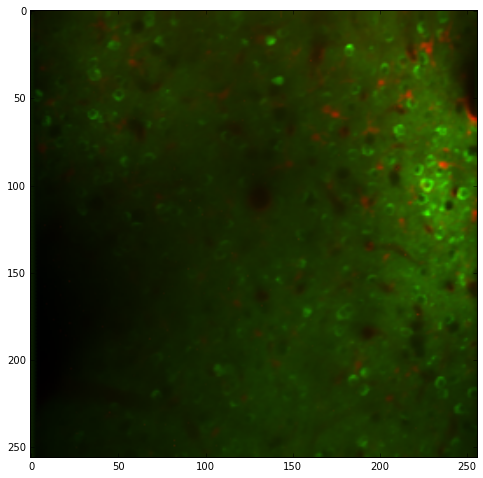

In [12]:
frames = preprocess.Prepare.GalvoAverageFrame() & keys[28] 
g, r = frames.fetch.order_by('channel')['frame']
plt.imshow(np.stack(
        [normalize(r), normalize(g), np.zeros_like(r)], 2))

## Example: Plot calcium traces and inferred spikes

Raw calcium traces are hosted in `preprocess.ComputeTraces.Trace` whereas inferred spikes are hosted in `preprocess.Spikes.RateTrace`.

In [13]:
calcium = preprocess.ComputeTraces.Trace()
spikes = preprocess.Spikes.RateTrace()
traces = calcium*spikes  # combined raw and spike rate traces
traces.heading

animal_id            : int                          # id number
session              : smallint                     # session index for the mouse
scan_idx             : smallint                     # number of TIFF stack file
extract_method       : tinyint                      # 
trace_id             : smallint                     # 
spike_method         : smallint                     # spike inference method
---
trace=null           : longblob                     # leave null same as ExtractRaw.Trace
rate_trace=null      : longblob                     # leave null same as ExtractRaw.Trace

---
### Select the preprocessing method

In [14]:
preprocess.Method.Galvo()   #  trace extraction methods for galvo imaging

extract_method,segmentation
1,manual
2,nmf


In [15]:
preprocess.SpikeMethod()

spike_method,spike_method_name,spike_method_details,language
2,fastoopsi,nonnegative sparse deconvolution from Vogelstein (2010),matlab
3,stm,spike triggered mixture model from Theis et al. (2016),python
4,improved oopsi,,matlab
5,nmf,,matlab


In [16]:
traces &= dict(extract_method=2, spike_method=3)
traces

animal_id,session,scan_idx,extract_method,trace_id,spike_method
7816,1,11,2,1,3
7816,1,11,2,2,3
7816,1,11,2,3,3
7816,1,11,2,4,3
7816,1,11,2,5,3
7816,1,11,2,6,3
7816,1,11,2,7,3


---
Let's plot a random trace:

In [17]:
key = np.random.choice(list(traces.fetch.keys()))
key

OrderedDict([('animal_id', 7816),
             ('session', 1),
             ('scan_idx', 20),
             ('extract_method', 2),
             ('trace_id', 42),
             ('spike_method', 3)])

In [18]:
# fetch synchronized times
times, nslices = (preprocess.Sync()*preprocess.Prepare.Galvo() & key).fetch1['frame_times', 'nslices']
times = times[0,::nslices] - times[0][0]  # start at 0


calcium, spikes = (traces & key).fetch1['trace', 'rate_trace']

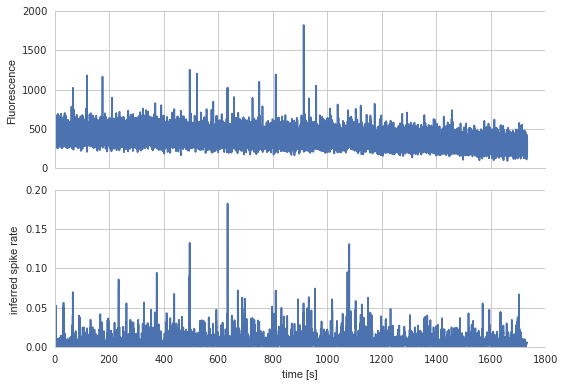

In [19]:
import seaborn as sns
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(times, calcium.squeeze(), label='Ca Trace')
ax[1].plot(times, spikes.squeeze(), label='Spike Rate')
ax[0].set_ylabel('Fluorescence')
ax[1].set_ylabel('inferred spike rate')
ax[1].set_xlabel('time [s]')
sns.despine(fig)
fig.tight_layout()

Next: [pipeline_vis](pipeline_vis.ipynb)